# Remove noisy background from images/documents using Auto-encoders, Tensorflow v2 and Keras

# About Autoencoders
An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”. Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name.

![](https://osclasspoint.com/kaggle/autoencoder.png)

# Import libraries and data
First load libraries we need for our work. We need multiple libraries to be able to unzip files, work with directories, sklearn, tensorflow...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

What kind of data/files we have there?

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/test.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/train.zip


As we have data zipped, we will have to work in /kaggle/working/ directory to unzip images here.

In [3]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [4]:
# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

For later use, we will store image names into list, so we can draw them simply.

In [5]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

# Data preparation
Next step is to define function to process images and then store this images in list. As there is not as many data, we do not need to work in batches.

In [6]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

Reshape images and put them into list.

In [7]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

# Exploratory data analysis
Not too much to look there, but just quickly look on train images and their cleaned version. This is what we put into model to learn how to clean noise from background.

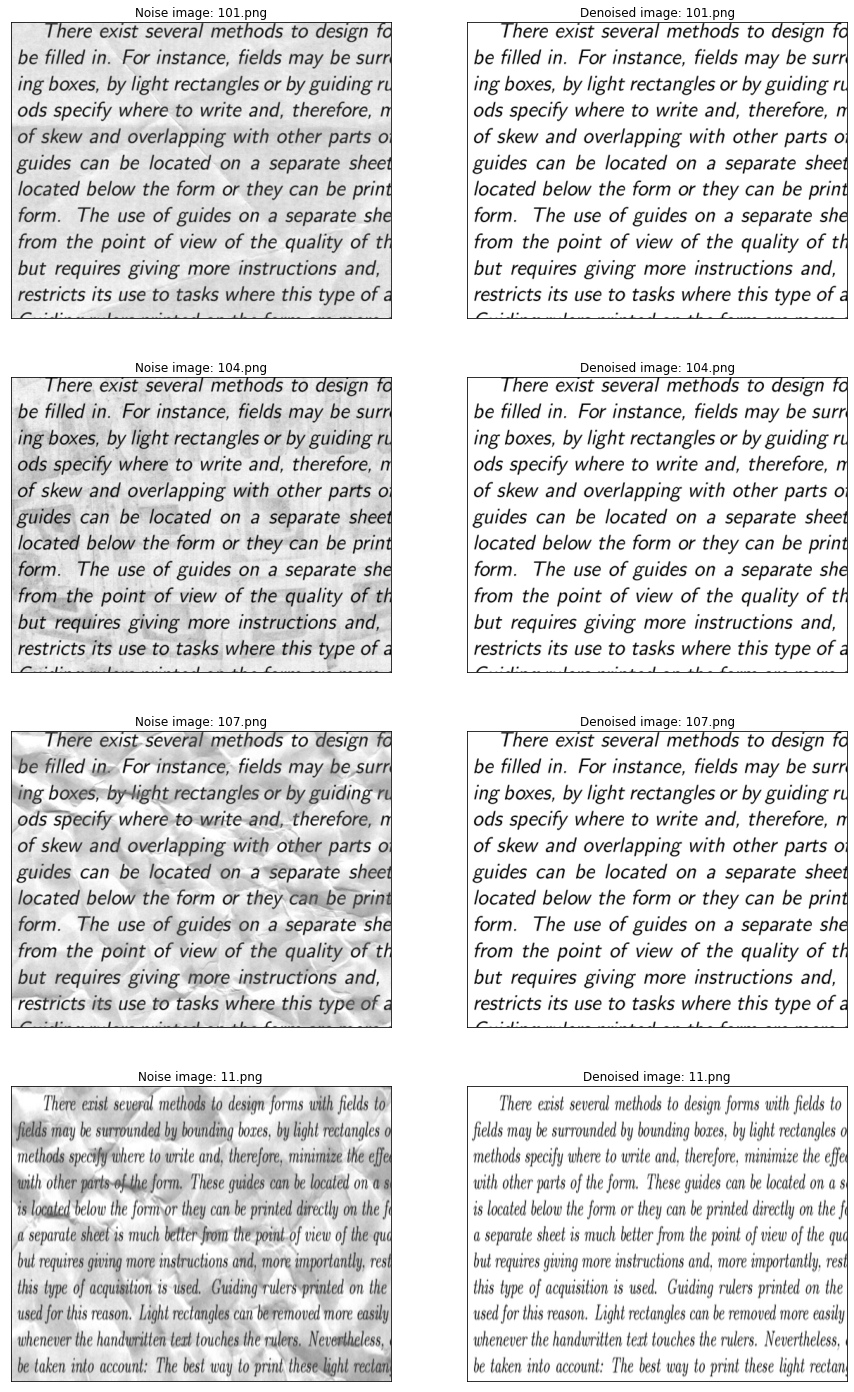

In [8]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

# Split data
In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

In [9]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

# Modeling
This is first time I am using functional modeling way in tensorflow. I've tried to go with model.add() and sequential model and it did not worked at all, results were really strange. Maybe you have idea why?

I have tested many different models and this one brought me to best results (val_loss < 0.0004). Increasing filters, adding another convolutional layer, batch normalization or drop out did not helped to get better score.

Model is pretty simple and it's nice to look at model summary how it works in terms of layer sizes.
420x540 -> 210x270 --> 210x270 -> 420x540

Adam as optimizer is used (as it worked best out of other optimizers), loss is based on mean squared error and we are looking on mean absolute error as well.

In [10]:
def model():
    input_layer = Input(shape=(420, 540, 1))  # we might define (None,None,1) here, but in model summary dims would not be visible
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization (BatchNo (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 128)     0         
_________________________________________________________________
dropout (Dropout)            (None, 210, 270, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 270, 128)    

## Train model
Verbose is going to be set to 0 to avoid filling output with hundreds of lines from training. We will run 300 epochs having early stopping set to 20 (if val loss does not drop in 20 epochs, it will stop).

Let's store history of model as well, so we can plot loss (rmse) and mae.

In [11]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=24, verbose=0, callbacks=[callback])

## Plot error evolution on epochs

You may notice jump in error after approx. 10 epoch that is pretty important, but enought epochs flatten this to almost 0.

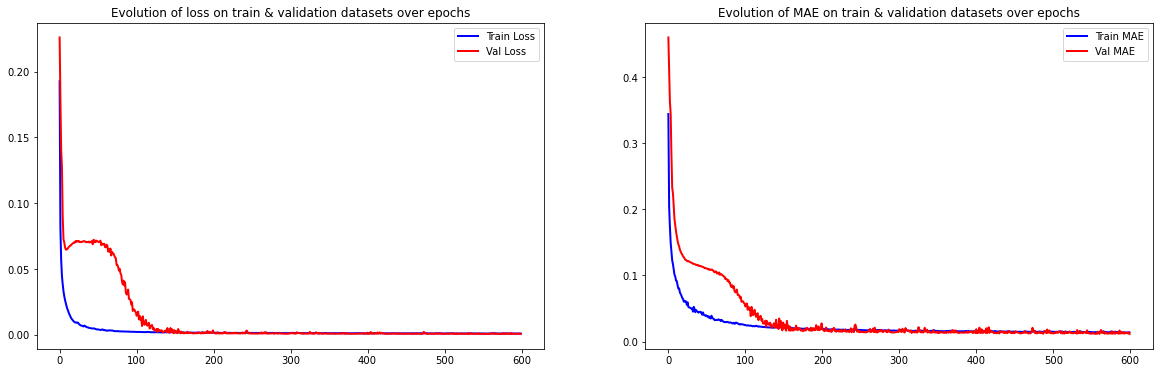

In [12]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


# Evaluation
In this step we will "predict", or better say clean test images and check how well model works.

In [13]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

Now compare noisy (left) and denoised test images (right). Our model has done great job with denoising!

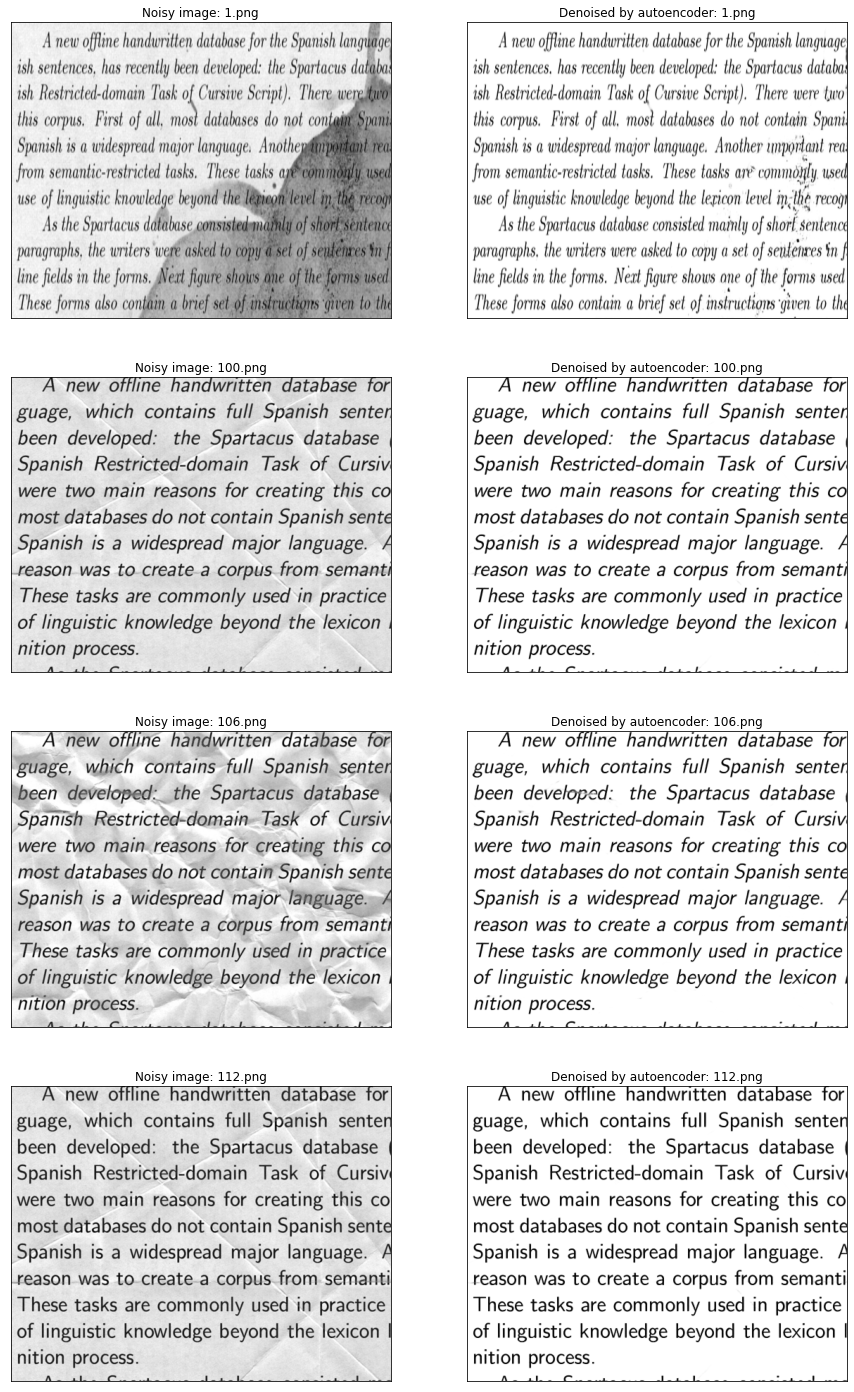

In [14]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

# Submission
It's time to contest! Let's submit our data.

Honestly, this way to submit results was really weird for me :-/

In [15]:
# it will take a while!
ids = []
vals = []
for i, f in enumerate(test_img):
    file = path + 'test/' + f
    imgid = int(f[:-4])
    img = cv2.imread(file, 0)
    img_shape = img.shape
    # print('Processing image: {} \tinto size: {}'.format(f, img_shape))    # uncomment to see progress
    preds_reshaped = cv2.resize(Y_test[i], (img_shape[1], img_shape[0]))

    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

submission = pd.DataFrame({'id': ids, 'value': vals})
submission.to_csv('submission.csv',index = False)

print('Results saved to submission.csv!')

# quick check if length of IDs is OK
# we should get there number 14230080
print('Length of IDs: {}'.format(len(ids)))

Results saved to submission.csv!
Length of IDs: 14230080


In [16]:
# check first few rows of submission
my_submission = pd.read_csv('submission.csv')
my_submission.head(5)

,id,value
0,1_1_1,0.978425
1,1_1_2,0.995079
2,1_1_3,0.994216
3,1_1_4,0.995372
4,1_1_5,0.996162


In [17]:
# cleanup working directory
import shutil
shutil.rmtree(path + 'train/')
shutil.rmtree(path + 'test/')
shutil.rmtree(path + 'train_cleaned/')

# Conclusion
We've created autoencoder using tensorflow v2 and keras that can very successfully remove background and noise from documents. Next step could me create algorithm that will be able to extract words out of cleaned sheets ;-)

I have really enjoyed this task, hope you did as well!

## If you liked this notebook, please UPVOTE
## Thanks !